In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pandas as pd

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from fracdiff.sklearn import Fracdiff,FracdiffStat
from scipy.stats import skew
from scipy.stats import kurtosis


from scipy.stats import jarque_bera
import statsmodels.api as sm

from hurst import compute_Hc

In [2]:
def prepare_data(path):
    df = pd.read_csv(path)
    df.columns = ['Date_vix']
    df['Date'] = df['Date_vix'].apply(lambda x: x[0:8])
    df['vix'] = df['Date_vix'].apply(lambda x: x[9:])
    df['vix'] = df['vix'].apply(lambda x: str.replace(x, ' ', ''))
    df['vix'] = df['vix'].apply(lambda x: 0.0 if x == '.' else x)
    df['vix'] = df['vix'].astype(float)
    df['log_vix'] = np.log(df['vix'])
    df['Date'] = pd.to_datetime(df['Date'])
    return df


In [3]:
df = prepare_data('./VIXdata.txt')

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
df = df.drop_duplicates()
df = df[df['vix']>0]
df['log_vix_diff'] = df['log_vix'].diff()
df.dropna(inplace=True)
df.head()

,Date_vix,Date,vix,log_vix,log_vix_diff
2,20010103 26.60,2001-01-03,26.60,3.280911,-0.119953
4,20010104 26.97,2001-01-04,26.97,3.294725,0.013814
6,20010105 28.67,2001-01-05,28.67,3.355851,0.061126
8,20010108 29.84,2001-01-08,29.84,3.395850,0.039998
10,20010109 27.99,2001-01-09,27.99,3.331847,-0.064002


In [5]:
d={'Date':df['Date'], 'VIX':df['vix'], 'Log VIX':df['log_vix'], 'Log diff':df['log_vix_diff']}

df_1 = pd.DataFrame(data=d)
df_1 = df_1.drop(df_1.index[:2262])
df_1=df_1.reset_index(drop=True)

In [6]:
df_1.head()

,Date,VIX,Log VIX,Log diff
0,2010-01-04,20.04,2.997730,-0.078660
1,2010-01-05,19.35,2.962692,-0.035038
2,2010-01-06,19.16,2.952825,-0.009868
3,2010-01-07,19.06,2.947592,-0.005233
4,2010-01-08,18.13,2.897568,-0.050024


# 1. 数据基本特征

In [7]:
x1 = df_1['VIX']
x2 = df_1['Log VIX']
x3 = df_1['Log diff']

In [19]:
# compute the mean
mean1 = np.mean(x1)
mean2 = np.mean(x2)
mean3 = np.mean(x3)

print("VIX的平均值: ", mean1)
print("Log VIX的平均值: ", mean2)
print("Log diff的平均值: ", mean3, end="\n\n")


# 计算最大值
max1 = np.max(x1)
max2 = np.max(x2)
max3 = np.max(x3)
print("VIX的最大值: ", max1)
print("Log VIX的最大值: ", max2)
print("Log diff的最大值: ", max3, end="\n\n")

# 计算最小值
min1 = np.min(x1)
min2 = np.min(x2)
min3 = np.min(x3)
print("VIX的最小值: ", min1)
print("Log VIX的最小值: ", min2)
print("Log diff的最小值: ", min3, end="\n\n")

# 计算标准差
std1 = np.std(x1)
std2 = np.std(x2)
std3 = np.std(x3)
print("VIX的标准差: ", std1)
print("Log VIX的标准差: ", std2)
print("Log diff的标准差: ", std3, end="\n\n")

VIX的平均值:  18.504864267676783
Log VIX的平均值:  2.857415799297398
Log diff的平均值:  -5.137513916725429e-06

VIX的最大值:  82.69
Log VIX的最大值:  4.415098675734075
Log diff的最大值:  0.7682450067910249

VIX的最小值:  9.14
Log VIX的最小值:  2.2126603854660587
Log diff的最小值:  -0.35058849788233015

VIX的标准差:  7.309483784869737
Log VIX的标准差:  0.33325699850329016
Log diff的标准差:  0.07933299717738503



In [30]:
# 计算偏度
skew1 = skew(x1)
skew2 = skew(x2)
skew3 = skew(x3)
print("VIX的偏度: ", skew1)
print("Log VIX的偏度: ", skew2)
print("Log diff的偏度: ", skew3, end="\n\n")

# 得出结论，skew>0,都是向右偏斜的

# 计算峰度
kurt1 = kurtosis(x1)
kurt2 = kurtosis(x2)
kurt3 = kurtosis(x3)
print("VIX的峰度: ", kurt1)
print("Log VIX的峰度: ", kurt2)
print("Log diff的峰度: ", kurt3, end="\n\n")

# 得出结论，kurtosis>0,都是尖峭的


VIX的偏度:  2.353071959775539
Log VIX的偏度:  0.762936970724947
Log diff的偏度:  1.1361847083210508

VIX的峰度:  10.33612371579837
Log VIX的峰度:  0.6954543384624818
Log diff的峰度:  6.168032541904122



# 2. 检验正态分布

In [38]:
# Jarque-Bera statistic

jb_stat1, jb_p1 = jarque_bera(x1)
print("Jarque-Bera statistic: ", jb_stat1)
print("Jarque-Bera p-value: ", jb_p1)

# 判断数据是否符合正态分布
if jb_p1 < 0.05:
    print("VIX is not normally distributed.", end="\n\n")
else:
    print("The data is normally distributed.")


jb_stat2, jb_p2 = jarque_bera(x2)
print("Jarque-Bera statistic: ", jb_stat2)
print("Jarque-Bera p-value: ", jb_p2)

# 判断数据是否符合正态分布
if jb_p2 < 0.05:
    print("Log VIX is not normally distributed.", end="\n\n")
else:
    print("The data is normally distributed.", end="\n\n")


jb_stat3, jb_p3 = jarque_bera(x3)
print("Jarque-Bera statistic: ", jb_stat3)
print("Jarque-Bera p-value: ", jb_p3)

# 判断数据是否符合正态分布
if jb_p3< 0.05:
    print("Log diff is not normally distributed.")
else:
    print("The data is normally distributed.", end="\n\n")

Jarque-Bera statistic:  17025.78821589584
Jarque-Bera p-value:  0.0
VIX is not normally distributed.

Jarque-Bera statistic:  371.1771389148401
Jarque-Bera p-value:  0.0
Log VIX is not normally distributed.

Jarque-Bera statistic:  5703.494042885574
Jarque-Bera p-value:  0.0
Log diff is not normally distributed.


# 3. 检验自相关性

In [57]:
# Q statistics VIX p<0.05 has autocorrelation
sm.stats.acorr_ljungbox(x1, lags=[5,10,20], return_df=True)


,lb_stat,lb_pvalue
5,13420.528419,0.0
10,24173.274469,0.0
20,39631.330956,0.0


In [58]:
# Q statistics Log VIX p<0.05 has autocorrelation
sm.stats.acorr_ljungbox(x2, lags=[5,10,20], return_df=True)

,lb_stat,lb_pvalue
5,13651.843954,0.0
10,24911.535725,0.0
20,42823.359537,0.0


In [59]:
# Q statistics Log diff p<0.05 has autocorrelation
sm.stats.acorr_ljungbox(x3, lags=[5,10,20], return_df=True)

,lb_stat,lb_pvalue
5,32.904878,0.000004
10,40.759320,0.000012
20,49.440432,0.000266


# 4. 检验平稳性

In [73]:
from arch.unitroot import ADF
adf1 = ADF(x1)
print(adf1.summary().as_text())

adf2 = ADF(x2)
print(adf2.summary().as_text())

adf3 = ADF(x3)
print(adf3.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -4.770
P-value                         0.000
Lags                               26
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
   Augmented Dickey-Fuller Results   
Test Statistic                 -5.260
P-value                         0.000
Lags                                6
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
   Augmented Dickey-Fuller Results   
Test Statistic                -23.373
P-value                         0.000
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Nu

In [75]:
from arch.unitroot import PhillipsPerron

pp1 = PhillipsPerron(x1)
print(pp1.summary().as_text())

pp2 = PhillipsPerron(x2)
print(pp2.summary().as_text())

pp3 = PhillipsPerron(x3)
print(pp3.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -6.922
P-value                         0.000
Lags                               29
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -6.046
P-value                         0.000
Lags                               29
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                -65.817
P-value                         0.000
Lags                               29
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Nu

In [79]:

from arch.unitroot import KPSS

kpss1 = KPSS(x1)
print(kpss1.summary().as_text())

kpss2 = KPSS(x2)
print(kpss2.summary().as_text())

kpss3 = KPSS(x3)
print(kpss3.summary().as_text())

    KPSS Stationarity Test Results   
Test Statistic                  0.908
P-value                         0.004
Lags                               32
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
    KPSS Stationarity Test Results   
Test Statistic                  1.089
P-value                         0.002
Lags                               32
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
    KPSS Stationarity Test Results   
Test Statistic                  0.016
P-value                         0.996
Lags                               23
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypoth

# add: d estimation

In [10]:
from fracdiff.sklearn import FracdiffStat

#X = ...  # 2d time-series with shape (n_samples, n_features)

f = FracdiffStat()
xx = f.fit_transform(x1.values.reshape(-1,1))
f.d_

array([0.])

In [12]:
from fracdiff.sklearn import FracdiffStat

#X = ...  # 2d time-series with shape (n_samples, n_features)

f = FracdiffStat()
xx = f.fit_transform(x2.values.reshape(-1,1))
f.d_

array([0.])

In [13]:
from fracdiff.sklearn import FracdiffStat

#X = ...  # 2d time-series with shape (n_samples, n_features)

f = FracdiffStat()
xx = f.fit_transform(x3.values.reshape(-1,1))
f.d_

array([0.])

# 5. Hurst exponent estimation

In [8]:
# 计算 Hurst 指数
H1, c1, _ = compute_Hc(x1, simplified=True)

# 输出 Hurst 指数
print("VIX Hurst exponent: ", H1, c1)

H2, c2, _ = compute_Hc(x2, simplified=True)
print("Log VIX Hurst exponent: ", H2, c2)

H3, c3, _ = compute_Hc(x3, simplified=True)
print("Log diff Hurst exponent: ", H3, c3)




VIX Hurst exponent:  0.39768413364799887 1.4792660675144707
Log VIX Hurst exponent:  0.34296655034138523 1.840142566014676
Log diff Hurst exponent:  0.23614470813427457 1.4015467552378658


In [111]:
# 定义一个时间序列数据集
data =x3

# 定义滚动窗口大小
window_size = 100

# 定义滚动窗口步长
step_size = 10

# 定义空列表存储 Hurst 指数
hurst100 = []

# 滚动计算 Hurst 指数
for i in range(0, len(data)-window_size+1):
    # 从时间序列数据中获取滚动窗口数据
    window_data = data[i:i+window_size]

    # 计算 Hurst 指数
    H, c, _ = compute_Hc(window_data, simplified=True)
    # 存储 Hurst 指数
    hurst100.append(H)

# 输出 Hurst 指数


In [107]:
# 定义滚动窗口大小
window_size = 120



# 定义空列表存储 Hurst 指数
hurst120 = []

# 滚动计算 Hurst 指数
for i in range(0, len(data)-window_size+1):
    # 从时间序列数据中获取滚动窗口数据
    window_data = data[i:i+window_size]

    # 计算 Hurst 指数
    H, c, _ = compute_Hc(window_data, simplified=True)
    # 存储 Hurst 指数
    hurst120.append(H)

In [106]:
# 定义滚动窗口大小
window_size = 150



# 定义空列表存储 Hurst 指数
hurst150 = []

# 滚动计算 Hurst 指数
for i in range(0, len(data)-window_size+1):
    # 从时间序列数据中获取滚动窗口数据
    window_data = data[i:i+window_size]

    # 计算 Hurst 指数
    H, c, _ = compute_Hc(window_data, simplified=True)
    # 存储 Hurst 指数
    hurst150.append(H)

In [109]:
len(hurst150)

3019

In [110]:
len(hurst120)

3049

In [124]:
len(hurst100[50:])

3019

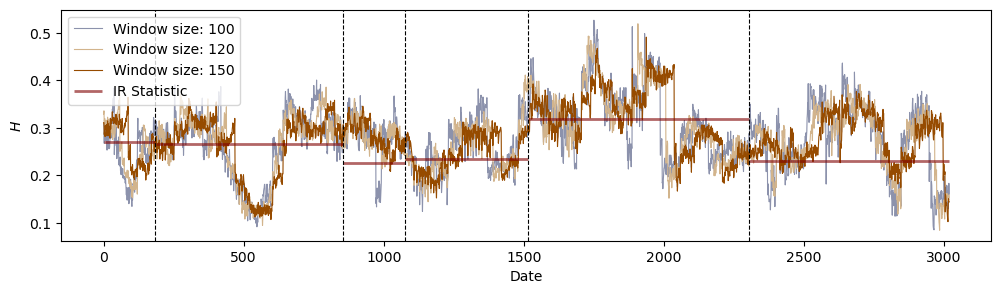

In [205]:
# 创建一个新的图形对象和一个子图对象
fig, ax = plt.subplots()

# 绘制一条曲线
x1=np.arange(len(hurst100)-50)
y1=hurst100[50:]
ax.plot(x1,y1,color='#8C92AC', linewidth=0.8, label='Window size: 100')

x2=np.arange(len(hurst120)-30)
y2=hurst120[30:]
ax.plot(x2,y2,color='#d2b48c', linewidth=0.8, label='Window size: 120')

x3=np.arange(len(hurst150))
y3=hurst150
ax.plot(x3,y3,color='#964B00', linewidth=0.8, label='Window size: 150')



# 设置颜色的 RGB 值
color_rgb = '#5f9ea0'


plt.hlines(y=0.270577,xmin=x1[0],xmax=x1[334-150],color='#800000',label='IR Statistic', linewidth=2,alpha=0.6)
plt.hlines(y=0.266048,xmin=x1[335-150],xmax=x1[1005-150],color='#800000', linewidth=2,alpha=0.6)
plt.hlines(y=0.22593,xmin=x1[1006-150],xmax=x1[1225-150],color='#800000', linewidth=2,alpha=0.6)
plt.hlines(y=0.23381,xmin=x1[1226-150],xmax=x1[1663-150],color='#800000', linewidth=2,alpha=0.6)
plt.hlines(y=0.319757,xmin=x1[1664-150],xmax=x1[2454-150],color='#800000', linewidth=2,alpha=0.6)
plt.hlines(y=0.231183,xmin=x1[2455-150],xmax=x1[3018],color='#800000', linewidth=2,alpha=0.6)



ax.axvline(x=x1[334-150], color='black', linewidth=0.8,linestyle='--')
ax.axvline(x=x1[1005-150], color='black', linewidth=0.8,linestyle='--')
ax.axvline(x=x1[1225-150], color='black', linewidth=0.8,linestyle='--')
ax.axvline(x=x1[1663-150], color='black', linewidth=0.8,linestyle='--')
ax.axvline(x=x1[2454-150], color='black', linewidth=0.8,linestyle='--')


# 显示图形
fig.set_size_inches(12, 3)

plt.legend()

plt.xlabel('Date')
plt.ylabel('$H$')
plt.savefig('FIG/H.png', dpi=800)
plt.show()

In [134]:
index = df_1[df_1['Date'] == '2011-07-13'].index
index

Int64Index([384], dtype='int64')

In [135]:
index = df_1[df_1['Date'] == '2013-12-31'].index
index


Int64Index([1005], dtype='int64')

In [136]:
index = df_1[df_1['Date'] == '2014-11-13'].index
index


Int64Index([1225], dtype='int64')

In [137]:
index = df_1[df_1['Date'] == '2016-8-11'].index
index


Int64Index([1663], dtype='int64')

In [138]:
index = df_1[df_1['Date'] == '2019-10-3'].index
index


Int64Index([2454], dtype='int64')

In [147]:

# Compute the Hurst through IR statistics

# period 1
x = df_1['Log diff']
HI1, cI1, _ = compute_Hc(x[:384], simplified=True)
print(HI1)

# period2
HI2, cI2, _ = compute_Hc(x[385:1005], simplified=True)
print(HI2)

# period3
HI3, cI3, _ = compute_Hc(x[1006:1225], simplified=True)
print(HI3)

# period4
HI4, cI4, _ = compute_Hc(x[1226:1663], simplified=True)
print(HI4)

# period5
HI5, cI5, _ = compute_Hc(x[1664:2454], simplified=True)
print(HI5)

# period6
HI6, cI6, _ = compute_Hc(x[2455:], simplified=True)
print(HI6)

0.2705766102926789
0.26604800383772886
0.2259295146232815
0.23381082420299373
0.3197577967082064
0.2311830878972157


In [172]:
len(x1)

3019